In [131]:
import os
import sys
import pathlib

PROJECT_FOLDER = pathlib.Path(os.getcwd()).resolve().parent
sys.path.append(str(PROJECT_FOLDER / 'src'))
from utils.dataset_utils import DatasetUtils

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.style as style

from pypfopt.efficient_frontier import EfficientFrontier 
from pypfopt import risk_models 
from pypfopt import expected_returns
from pypfopt.cla import CLA
import pypfopt.plotting as pplt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

# Настройки графиков
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline


style.use('seaborn-poster')
style.use('ggplot')

CUR_FILE_PATH = pathlib.Path(os.getcwd()).resolve()
DATA_PATH = CUR_FILE_PATH.parent.resolve() / 'data'
CUR_FILE_PATH

/var/folders/yx/7yys56tx67z0yvn74khb_1480000gp/T/ipykernel_59999/807797936.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-poster')


PosixPath('/Users/Kirill/Documents/stocks-prediction/notebooks')

# Подготовка данных для анализа

In [132]:
data_dict.values()

dict_values([          <TIME> <TICKER>  <PER>  <OPEN>  <HIGH>   <LOW>  <CLOSE>    <VOL>  \
<DATE>                                                                       
20210111  230000     MTSS     60  337.35  337.85  336.00   337.75  4087100   
20210112  230000     MTSS     60  333.40  334.00  333.25   333.85  3439790   
20210113  230000     MTSS     60  331.90  332.25  331.40   331.45  2926100   
20210114  230000     MTSS     60  336.90  338.40  336.50   337.75  3251780   
20210115  230000     MTSS     60  334.65  334.75  333.20   333.35  2567540   
...          ...      ...    ...     ...     ...     ...      ...      ...   
20230527  100000     MTSS     60  307.65  308.15  307.20   308.00   160800   
20230529  230000     MTSS     60  313.30  314.55  313.20   314.35  5060590   
20230530  230000     MTSS     60  316.50  317.75  316.50   317.30  6265990   
20230531  230000     MTSS     60  316.90  317.00  316.00   316.50  4072620   
20230601  100000     MTSS     60  316.50  317.15  3

In [133]:
data_dict = {}
for stock_file in DATA_PATH.iterdir():
    if stock_file.stem == '.gitkeep':
        continue
    data_dict[stock_file.stem.split('_')[0]] = DatasetUtils().get_daily_df(stock_file)

stock_names =  [k for k in data_dict.keys()]
stock_values = [v for v in data_dict.values()]

for i in range(len(stock_values)):
    stock_values[i].reset_index(inplace = True, drop = True)
    stock_values[i].set_index('<DATE>', inplace = True)

    # DatasetUtils.create_datetime(stock_values[i], '<DATE>', '<TIME>')


combined_df = None
for idx, stocks_data in enumerate(data_dict.items()):
    stocks_name, stocks_df = stocks_data
    if idx == 0:
        combined_df = stocks_df[['<CLOSE>']]
        previous_name = stocks_name
        continue
    combined_df = combined_df.join(stocks_df[['<CLOSE>']], lsuffix=previous_name, rsuffix=stocks_name)
    previous_name = stocks_name

close_prices_df = pd.DataFrame()
close_prices_df[stock_names]  = combined_df.dropna()

# Расчеты по оптимизации портфеля

Перейдем к расчетам по оптимизации портфеля и начнем с определения ожидаемой доходности и дисперсии портфеля. Далее сохраним значения весов портфеля с максимальным коэффициентом Шарпа и минимальной дисперсией.

In [134]:
close_prices_df.reset_index(inplace = True, drop = False)
close_prices_df['<DATE>'] = pd.to_datetime(close_prices_df['<DATE>'].astype(str), format='%Y%m%d')
close_prices_df.set_index('<DATE>', inplace = True)

In [135]:
#Годовая доходность
mu = expected_returns.mean_historical_return(close_prices_df) 
#Дисперсия портфеля
Sigma = risk_models.sample_cov(close_prices_df)
#Максимальный коэффициент Шарпа
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) #weight bounds in negative allows shorting of stocks
sharpe_pfolio=ef.max_sharpe() #May use add objective to ensure minimum zero weighting to individual stocks
sharpe_pwt=ef.clean_weights()
print(sharpe_pwt)

OrderedDict([('MTSS', 0.0), ('MOEX', 0.0), ('VTBR', 0.0), ('IRAO', 0.0), ('MTLR', 1.0), ('NLMK', 0.0), ('ROSN', 0.0), ('SNGS', 0.0), ('LKOH', 0.0), ('ALRS', 0.0), ('RTSI', 0.0), ('HYDR', 0.0), ('AFLT', 0.0), ('GAZP', 0.0), ('GMKN', 0.0), ('SBER', 0.0), ('YNDX', 0.0), ('MGNT', 0.0)])


Так как есть структурный сдвиг, то рассмотрим значения, которые получились бы до и после него

In [136]:
close_prices_df[289:]

,MTSS,MOEX,VTBR,IRAO,MTLR,NLMK,ROSN,SNGS,LKOH,ALRS,RTSI,HYDR,AFLT,GAZP,GMKN,SBER,YNDX,MGNT
<DATE>,,,,,,,,,,,,,,,,,,
2022-03-29,174.70,88.42,0.016500,1.9890,82.90,158.02,370.00,21.400,4922.0,84.40,881.59,0.6200,30.10,208.00,20028.0,128.77,2020.0,3405.5
2022-03-30,233.00,92.00,0.017155,2.4970,93.20,167.00,387.00,22.440,5140.0,87.90,949.23,0.6455,37.54,216.00,20462.0,134.60,2154.0,3855.0
2022-03-31,238.65,99.50,0.019800,2.7255,102.44,171.90,437.50,24.700,5680.0,95.70,1021.28,0.7135,37.74,242.48,20974.0,143.69,2259.0,4155.0
2022-04-01,235.00,111.45,0.022500,2.8800,103.00,173.20,450.00,26.500,5601.0,94.02,1033.58,0.7665,38.80,251.40,21500.0,154.50,2325.0,4220.0
2022-04-04,231.00,111.07,0.025100,2.8625,102.73,171.90,443.90,28.000,5557.0,94.70,1051.68,0.7550,40.90,252.90,21750.0,166.00,2285.0,4273.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-25,306.50,113.51,0.023150,4.2990,189.91,137.92,431.55,24.210,5202.0,66.34,1040.48,0.8190,40.12,161.99,14574.0,243.99,2335.2,4031.5
2023-05-26,307.65,114.39,0.023265,4.3645,191.58,139.10,432.50,24.325,5296.5,66.74,1055.63,0.8327,40.04,164.62,14684.0,248.30,2322.8,4135.0
2023-05-29,314.35,115.56,0.023245,4.1845,188.61,141.82,439.50,24.800,5535.0,66.93,1064.18,0.8565,40.54,163.47,14652.0,251.70,2386.4,4119.0


In [137]:
close_prices_df_before = close_prices_df[:285]
close_prices_df_after = close_prices_df[289:]

In [138]:
#Годовая доходность
mu_before = expected_returns.mean_historical_return(close_prices_df_before) 
#Дисперсия портфеля
Sigma_before = risk_models.sample_cov(close_prices_df_before)
#Максимальный коэффициент Шарпа
ef_before = EfficientFrontier(mu_before, Sigma_before, weight_bounds=(0,1)) #weight bounds in negative allows shorting of stocks
sharpe_pfolio_before=ef_before.max_sharpe() #May use add objective to ensure minimum zero weighting to individual stocks
sharpe_pw_before=ef_before.clean_weights()
print(sharpe_pwt)

OrderedDict([('MTSS', 0.0), ('MOEX', 0.0), ('VTBR', 0.0), ('IRAO', 0.0), ('MTLR', 1.0), ('NLMK', 0.0), ('ROSN', 0.0), ('SNGS', 0.0), ('LKOH', 0.0), ('ALRS', 0.0), ('RTSI', 0.0), ('HYDR', 0.0), ('AFLT', 0.0), ('GAZP', 0.0), ('GMKN', 0.0), ('SBER', 0.0), ('YNDX', 0.0), ('MGNT', 0.0)])


In [139]:
#Годовая доходность
mu_after = expected_returns.mean_historical_return(close_prices_df_after) 
#Дисперсия портфеля
Sigma_after = risk_models.sample_cov(close_prices_df_after)
#Максимальный коэффициент Шарпа
ef_after = EfficientFrontier(mu_after, Sigma_after, weight_bounds=(0,1)) #weight bounds in negative allows shorting of stocks
sharpe_pfolio_after=ef_after.max_sharpe() #May use add objective to ensure minimum zero weighting to individual stocks
sharpe_pw_after=ef_after.clean_weights()
print(sharpe_pwt)

OrderedDict([('MTSS', 0.0), ('MOEX', 0.0), ('VTBR', 0.0), ('IRAO', 0.0), ('MTLR', 1.0), ('NLMK', 0.0), ('ROSN', 0.0), ('SNGS', 0.0), ('LKOH', 0.0), ('ALRS', 0.0), ('RTSI', 0.0), ('HYDR', 0.0), ('AFLT', 0.0), ('GAZP', 0.0), ('GMKN', 0.0), ('SBER', 0.0), ('YNDX', 0.0), ('MGNT', 0.0)])


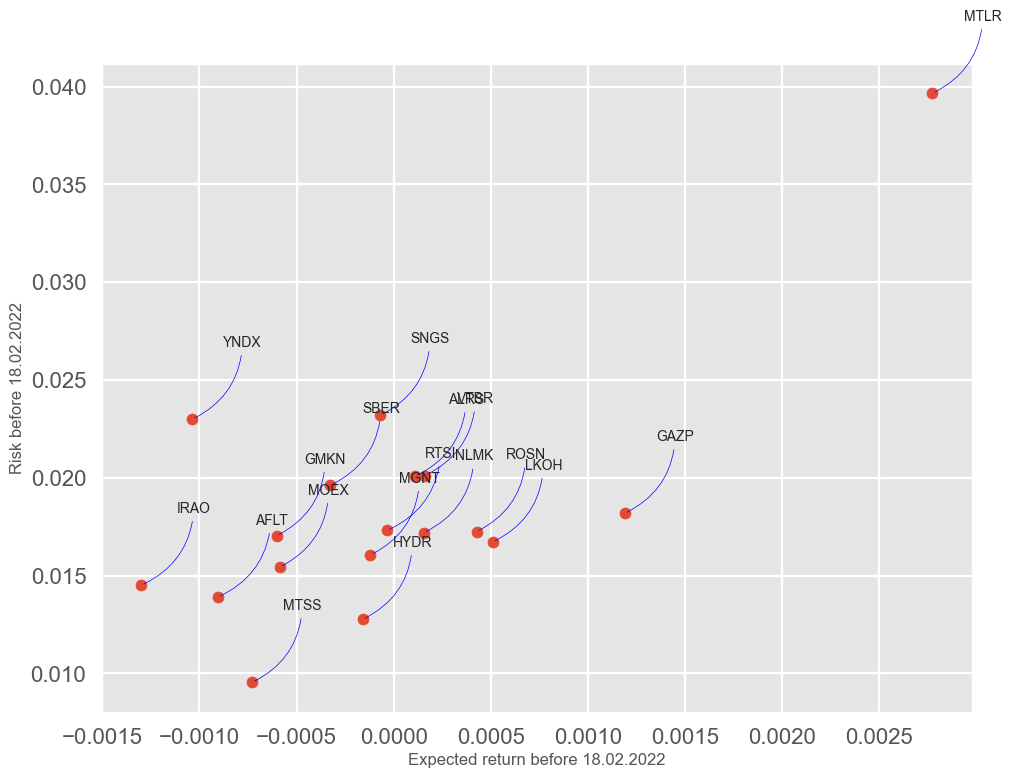

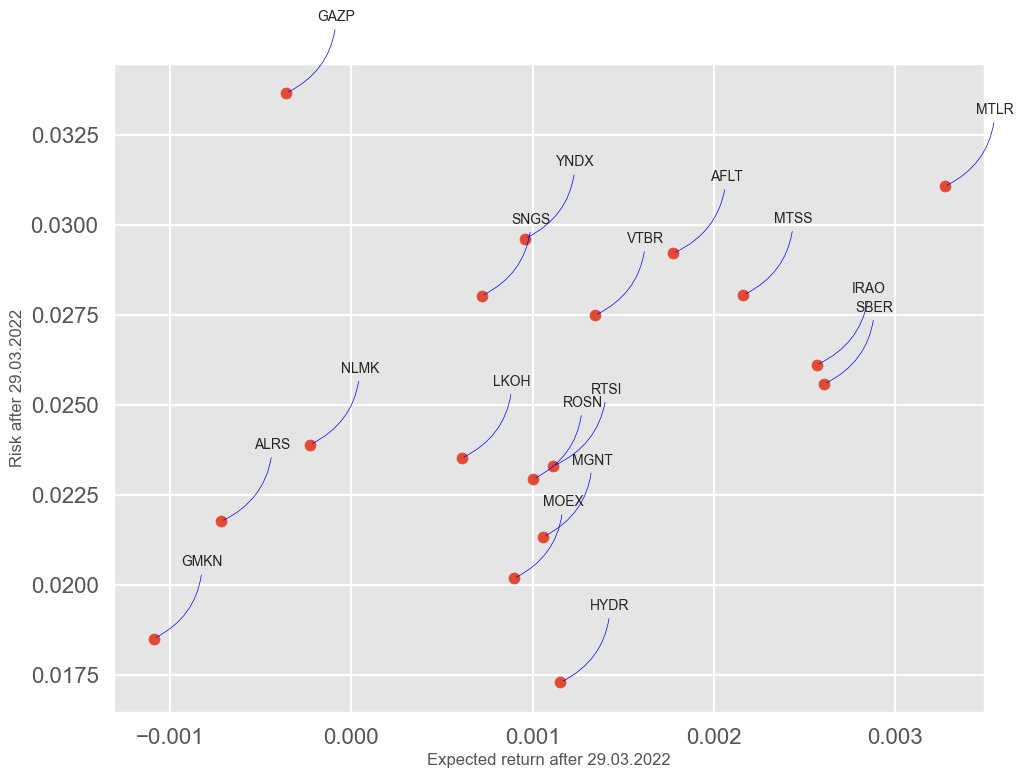

In [140]:
for company in stock_values:
    company['Daily Return'] = company['<CLOSE>'].pct_change()

combined_df = None
for idx, stocks_data in enumerate(data_dict.items()):
    stocks_name, stocks_df = stocks_data
    if idx == 0:
        combined_df = stocks_df[['Daily Return']]
        previous_name = stocks_name
        continue
    combined_df = combined_df.join(stocks_df[['Daily Return']], lsuffix=previous_name, rsuffix=stocks_name)
    previous_name = stocks_name

daily_return_df = pd.DataFrame()
daily_return_df[stock_names]  = combined_df.dropna()

daily_return_df.reset_index(inplace = True, drop = False)
daily_return_df['<DATE>'] = pd.to_datetime(daily_return_df['<DATE>'].astype(str), format='%Y%m%d')
daily_return_df.set_index('<DATE>', inplace = True)

daily_return_df_before = daily_return_df[:284]
daily_return_df_after = daily_return_df[288:]

area = np.pi * 20
plt.figure(figsize=(10, 8))
plt.scatter(daily_return_df_before.mean(), daily_return_df_before.std(), s=area)
plt.xlabel('Expected return before 18.02.2022')
plt.ylabel('Risk before 18.02.2022')

for label, x, y in zip(daily_return_df_before.columns, daily_return_df_before.mean(), daily_return_df_before.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
    
plt.figure(figsize=(10, 8))
plt.scatter(daily_return_df_after.mean(), daily_return_df_after.std(), s=area)
plt.xlabel('Expected return after 29.03.2022')
plt.ylabel('Risk after 29.03.2022')

for label, x, y in zip(daily_return_df_after.columns, daily_return_df_after.mean(), daily_return_df_after.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

Посмотрим общие характеристики по портфелю.

In [141]:
print('Total:')
ef.portfolio_performance(verbose=True)
print('''___________________________
Before:''')
ef_before.portfolio_performance(verbose=True)
print('''___________________________
After:''')
ef_after.portfolio_performance(verbose=True)

Total:
Expected annual return: 41.6%
Annual volatility: 66.2%
Sharpe Ratio: 0.60
___________________________
Before:
Expected annual return: 42.5%
Annual volatility: 33.5%
Sharpe Ratio: 1.21
___________________________
After:
Expected annual return: 83.8%
Annual volatility: 35.2%
Sharpe Ratio: 2.32


(0.8380072415241528, 0.3521004628229418, 2.3232211482081984)

Теперь посмотрим портфель, который показывает минимальную волатильность:

In [142]:
print('Total:')
ef1 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) 
minvol=ef1.min_volatility()
minvol_pwt=ef1.clean_weights()
print(minvol_pwt)
ef1.portfolio_performance(verbose=True, risk_free_rate = 0.27)
print('''___________________________
Before:''')
ef1_before = EfficientFrontier(mu_before, Sigma_before, weight_bounds=(0,1)) 
minvol_before=ef1_before.min_volatility()
minvol_pwt_before=ef1_before.clean_weights()
print(minvol_pwt_before)
ef1_before.portfolio_performance(verbose=True, risk_free_rate = 0.27)
print('''___________________________
After:''')
ef1_after = EfficientFrontier(mu_after, Sigma_after, weight_bounds=(0,1)) 
minvol_after=ef1_after.min_volatility()
minvol_pwt_after=ef1_after.clean_weights()
print(minvol_pwt_after)
ef1_after.portfolio_performance(verbose=True, risk_free_rate = 0.27)


Total:
OrderedDict([('MTSS', 0.06977), ('MOEX', 0.16066), ('VTBR', 0.0), ('IRAO', 0.0), ('MTLR', 0.0), ('NLMK', 0.03109), ('ROSN', 0.0), ('SNGS', 0.0), ('LKOH', 0.07132), ('ALRS', 0.02808), ('RTSI', 0.0), ('HYDR', 0.39741), ('AFLT', 0.0), ('GAZP', 0.0), ('GMKN', 0.24168), ('SBER', 0.0), ('YNDX', 0.0), ('MGNT', 0.0)])
Expected annual return: -8.1%
Annual volatility: 24.2%
Sharpe Ratio: -1.45
___________________________
Before:
OrderedDict([('MTSS', 0.58645), ('MOEX', 0.07466), ('VTBR', 0.0), ('IRAO', 0.00467), ('MTLR', 0.0), ('NLMK', 0.0821), ('ROSN', 0.0), ('SNGS', 0.01221), ('LKOH', 0.01669), ('ALRS', 0.0), ('RTSI', 0.0), ('HYDR', 0.1483), ('AFLT', 0.07339), ('GAZP', 0.0), ('GMKN', 0.00153), ('SBER', 0.0), ('YNDX', 0.0), ('MGNT', 0.0)])
Expected annual return: -13.6%
Annual volatility: 13.6%
Sharpe Ratio: -2.99
___________________________
After:
OrderedDict([('MTSS', 0.04262), ('MOEX', 0.04382), ('VTBR', 0.0), ('IRAO', 0.0), ('MTLR', 0.0), ('NLMK', 0.0), ('ROSN', 0.0), ('SNGS', 0.0), 

(0.13110770043030961, 0.22954534395054876, -0.6050756559872202)

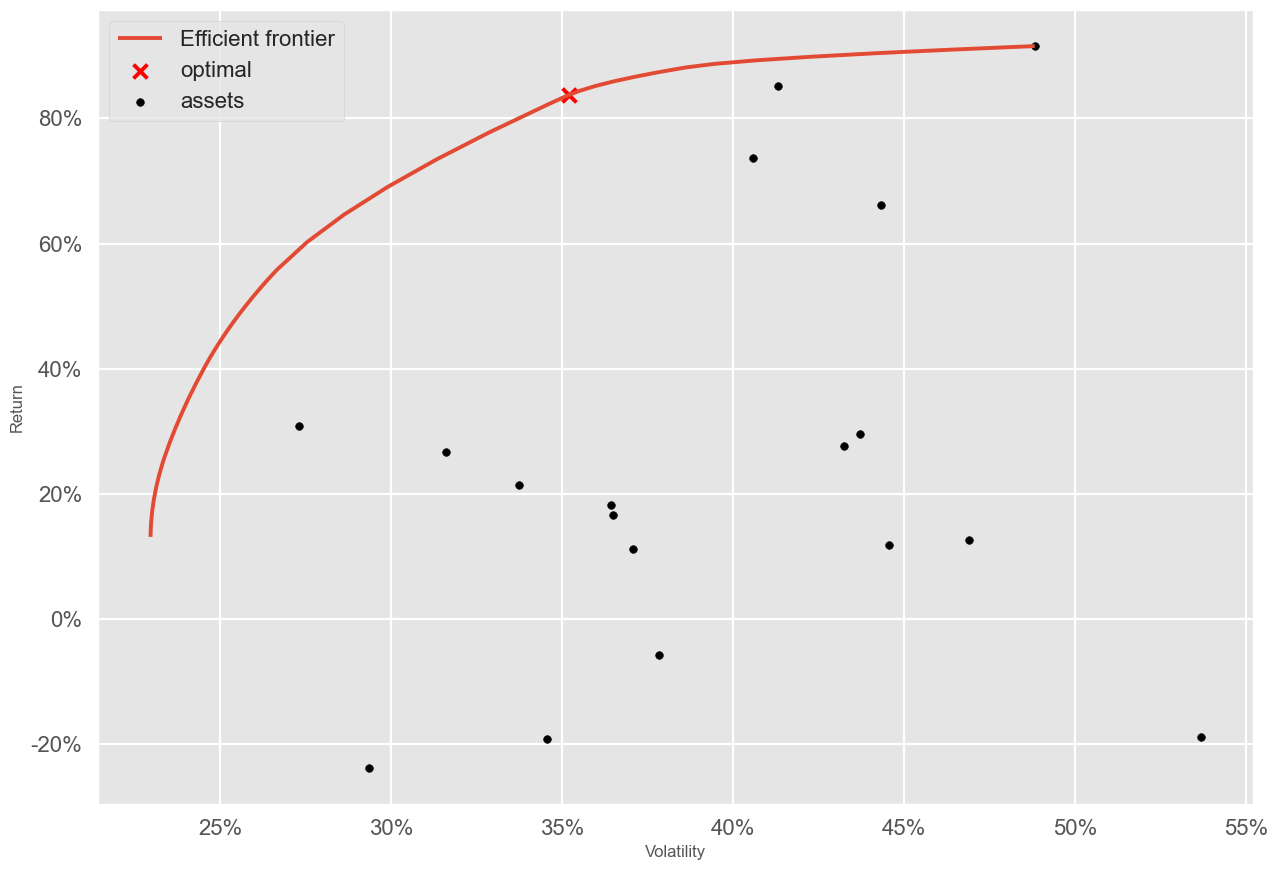

In [143]:
cl_obj = CLA(mu_after, Sigma_after)
ax = pplt.plot_efficient_frontier(cl_obj, showfig = False)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))